In [16]:
# Stock Price Prediction: LSTM vs Hybrid (Price + Sentiment)

import pandas as pd
import numpy as np
import yfinance as yf
import nltk
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [17]:
# ---------------------------
# 1. Load Tesla stock data
# ---------------------------
# 1. Download data (MultiIndex columns)
# Download and reset
stock_df = yf.download("TSLA", start="2009-01-01", end="2017-01-01", group_by='ticker')
stock_df = stock_df.reset_index()

# Flatten column names (join MultiIndex tuples)
stock_df.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in stock_df.columns]

# Print column names to verify
print("📊 Flattened column names:", stock_df.columns.tolist())

# Auto-detect and extract Close column
close_col = next((col for col in stock_df.columns if 'Close' in col), None)

if close_col:
    stock_df = stock_df[['Date_', close_col]]
    stock_df.rename(columns={'Date_': 'Date', close_col: 'Close'}, inplace=True)
    print(f"✅ Using column: {close_col}")
else:
    raise ValueError("❌ 'Close' column not found in stock_df.")





[*********************100%***********************]  1 of 1 completed

📊 Flattened column names: ['Date_', 'TSLA_Open', 'TSLA_High', 'TSLA_Low', 'TSLA_Close', 'TSLA_Volume']
✅ Using column: TSLA_Close


In [29]:
print(stock_df.columns)
print(stock_df.head(3))
print(stock_df['Close'].describe())


Index(['Date', 'Close'], dtype='object')
        Date     Close
0 2010-06-29  1.592667
1 2010-06-30  1.588667
2 2010-07-01  1.464000
count    1640.000000
mean        8.577300
std         6.221037
min         1.053333
25%         1.969333
50%         9.828333
75%        14.510834
max        19.069332
Name: Close, dtype: float64


In [19]:
# ---------------------------
# 2. Load & Filter News Data
# ---------------------------
df = pd.read_csv("reddit_worldnews_start_to_2016-11-22.csv/reddit_worldnews_start_to_2016-11-22.csv")
df['date_created'] = pd.to_datetime(df['date_created'], errors='coerce')
df = df[df['title'].str.contains("Tesla|Elon Musk", case=False, na=False)].copy()


In [20]:

# ---------------------------
# 3. Sentiment Analysis (VADER)
# ---------------------------
nltk.download('vader_lexicon')
vader = SentimentIntensityAnalyzer()
df['sentiment_score'] = df['title'].apply(lambda x: vader.polarity_scores(str(x))['compound'])


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\usalc\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [21]:
# ---------------------------
# 4. Aggregate Daily Sentiment
# ---------------------------
daily_sentiment = df.groupby(df['date_created'].dt.date)['sentiment_score'].mean().reset_index()
daily_sentiment.columns = ['Date', 'avg_sentiment']
daily_sentiment['Date'] = pd.to_datetime(daily_sentiment['Date'])


In [30]:
print(daily_sentiment.columns)
print(daily_sentiment.head(3))
print(daily_sentiment['avg_sentiment'].describe())


Index(['Date', 'avg_sentiment'], dtype='object')
        Date  avg_sentiment
0 2009-04-02         0.0000
1 2010-01-21        -0.2023
2 2010-02-17        -0.7650
count    162.000000
mean      -0.044897
std        0.312759
min       -0.844200
25%       -0.202300
50%        0.000000
75%        0.000000
max        0.900100
Name: avg_sentiment, dtype: float64


In [22]:
# ---------------------------
# 5. Merge stock + sentiment
# ---------------------------
merged = pd.merge(stock_df, daily_sentiment, on='Date', how='inner')


In [31]:
print(merged.head())
print(merged[['Close', 'avg_sentiment']].describe())


        Date     Close  avg_sentiment
0 2011-07-12  1.878000         0.4939
1 2012-07-13  2.283333         0.0000
2 2012-08-16  2.020000         0.0000
3 2013-03-07  2.548667        -0.4215
4 2013-06-13  6.545333        -0.4380
            Close  avg_sentiment
count  132.000000     132.000000
mean    13.669146      -0.041166
std      2.959194       0.293387
min      1.878000      -0.836000
25%     12.979667      -0.110004
50%     14.150667       0.000000
75%     15.174333       0.000000
max     18.008667       0.807400


In [23]:
# ---------------------------
# 6. Normalize and create sequences
# ---------------------------
scaler = MinMaxScaler()
scaled_hybrid = scaler.fit_transform(merged[['Close', 'avg_sentiment']])

def create_sequences(data, seq_len=60):
    x, y = [], []
    for i in range(seq_len, len(data)):
        x.append(data[i-seq_len:i])
        y.append(data[i, 0])  # predict Close
    return np.array(x), np.array(y)

x_hybrid, y_hybrid = create_sequences(scaled_hybrid)


In [32]:
print("x_price shape:", x_price.shape)
print("y_price shape:", y_price.shape)
print("x_hybrid shape:", x_hybrid.shape)
print("y_hybrid shape:", y_hybrid.shape)


x_price shape: (72, 60, 1)
y_price shape: (72, 1)
x_hybrid shape: (72, 60, 2)
y_hybrid shape: (72,)


In [24]:
# ---------------------------
# 7. Train Hybrid LSTM
# ---------------------------
model_hybrid = Sequential()
model_hybrid.add(LSTM(50, return_sequences=True, input_shape=(x_hybrid.shape[1], x_hybrid.shape[2])))
model_hybrid.add(LSTM(50))
model_hybrid.add(Dense(1))
model_hybrid.compile(optimizer='adam', loss='mse')
model_hybrid.fit(x_hybrid, y_hybrid, epochs=20, batch_size=16)

# Predict hybrid
pred_hybrid = model_hybrid.predict(x_hybrid)
dummy = np.zeros((pred_hybrid.shape[0], 2))
dummy[:, 0] = pred_hybrid[:, 0]
inv_pred_hybrid = scaler.inverse_transform(dummy)[:, 0]
actual_hybrid = merged['Close'].values[60:]


Epoch 1/20


d:\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.5385
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0595
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0654
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0079
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0207
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0097
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0084
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0086
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0046
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0068
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0062
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0053
Epoch 13/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0065
Epoch 14/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0059
Epoch 15/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0060
Epoch 16/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/

📊 stock_df columns: Index(['Date', 'Close'], dtype='object')
🔍 stock_df sample:
        Date     Close
0 2010-06-29  1.592667
1 2010-06-30  1.588667
2 2010-07-01  1.464000

📊 daily_sentiment columns: Index(['Date', 'avg_sentiment'], dtype='object')
🔍 daily_sentiment sample:
        Date  avg_sentiment
0 2009-04-02         0.0000
1 2010-01-21        -0.2023
2 2010-02-17        -0.7650


In [26]:
# ---------------------------
# 8. Train Price-Only LSTM
# ---------------------------
scaled_price = scaler.fit_transform(merged[['Close']])

def create_price_sequences(data, seq_len=60):
    x, y = [], []
    for i in range(seq_len, len(data)):
        x.append(data[i-seq_len:i])
        y.append(data[i])
    return np.array(x), np.array(y)

x_price, y_price = create_price_sequences(scaled_price)
x_price = x_price.reshape((x_price.shape[0], x_price.shape[1], 1))

model_price = Sequential()
model_price.add(LSTM(50, return_sequences=True, input_shape=(x_price.shape[1], 1)))
model_price.add(LSTM(50))
model_price.add(Dense(1))
model_price.compile(optimizer='adam', loss='mse')
model_price.fit(x_price, y_price, epochs=20, batch_size=16)

# Predict price-only
pred_price = model_price.predict(x_price)
inv_pred_price_only = scaler.inverse_transform(pred_price)
actual_price = merged['Close'].values[60:]


Epoch 1/20


d:\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.4714
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0460
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0558
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0136
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0225
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0096
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0090
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0077
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0069
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0078
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0054
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0058
Epoch 13/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0059
Epoch 14/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0057
Epoch 15/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0062
Epoch 16/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/

In [33]:
print("Actual Price Sample:", actual_price[:3])
print("Predicted Price-Only Sample:", inv_pred_price_only[:3])
print("Predicted Hybrid Sample:", inv_pred_hybrid[:3])


Actual Price Sample: [17.19466782 17.6546669  17.3326664 ]
Predicted Price-Only Sample: [[14.860288]
 [15.030126]
 [15.197903]]
Predicted Hybrid Sample: [15.11489028 15.30726839 15.31047006]


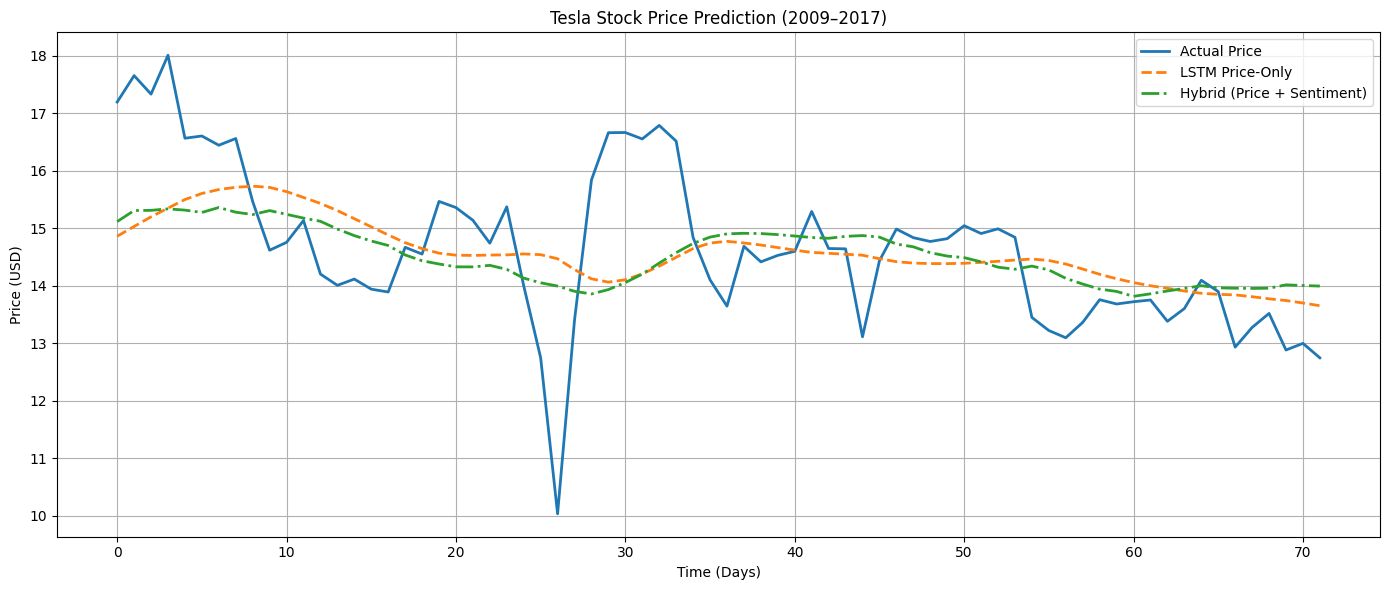

In [27]:
# 9. Plot both models
# ---------------------------
plt.figure(figsize=(14, 6))
plt.plot(actual_price, label='Actual Price', linewidth=2)
plt.plot(inv_pred_price_only, label='LSTM Price-Only', linestyle='--', linewidth=2)
plt.plot(inv_pred_hybrid, label='Hybrid (Price + Sentiment)', linestyle='-.', linewidth=2)
plt.title("Tesla Stock Price Prediction (2009–2017)")
plt.xlabel("Time (Days)")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [28]:

# ---------------------------
# 10. Evaluate
# ---------------------------
rmse_price = np.sqrt(mean_squared_error(actual_price, inv_pred_price_only))
mae_price = mean_absolute_error(actual_price, inv_pred_price_only)

rmse_hybrid = np.sqrt(mean_squared_error(actual_hybrid, inv_pred_hybrid))
mae_hybrid = mean_absolute_error(actual_hybrid, inv_pred_hybrid)

print("\n📈 LSTM Price-Only:")
print(f"  RMSE: {rmse_price:.2f}")
print(f"  MAE: {mae_price:.2f}")

print("\n🧠 Hybrid LSTM (Price + Sentiment):")
print(f"  RMSE: {rmse_hybrid:.2f}")
print(f"  MAE: {mae_hybrid:.2f}")



📈 LSTM Price-Only:
  RMSE: 1.24
  MAE: 0.93

🧠 Hybrid LSTM (Price + Sentiment):
  RMSE: 1.20
  MAE: 0.90
